# NeedleGX: Needle-Based Graph Inference Acceleration Extension

### Unified GNN framework for hardware-aware runtime optimization across CPUs, CUDA Cores, and Tensor Cores


<img src="https://drive.google.com/uc?export=view&id=1vn8FnmL1c-IMO_sXlgCPlO7J80PrYXuz" width="300">

### **[Code](https://drive.google.com/drive/folders/1D4cSA7cayTSlZbrRJz6S8cdlWR9Q2HD0?usp=sharing) | [Video](https://www.youtube.com/watch?v=_pV5XCpGG5g)**



---



## Graph Neural Networks (GNNs)

Graph Neural Networks (GNNs) are specialized neural architectures designed to process graph-structured data, where nodes represent entities and edges represent relationships.

**[Graph Convolutional Networks (GCNs)](https://arxiv.org/abs/1609.02907)** are the most widely adopted GNN architecture. GCNs learn node representations by aggregating features from neighboring nodes. Formally, a GCN takes a node feature matrix $X \in \mathbb{R}^{N \times F}$ and an adjacency matrix $A \in \mathbb{R}^{N \times N}$ as input, where $N$ denotes the number of nodes and $F$ is the feature dimension.

<img src="https://drive.google.com/uc?export=view&id=1N89tKE5yzq36A3FZGRn93l11KMpGt4Se" width="700">

Each GCN layer performs three core operations:

1. **GEMM (General Matrix-Matrix Multiplication)**: Dense matrix multiplication for feature transformation. GEMM operations leverage mature, highly-optimized libraries on both CPU and GPU.

2. **SpMM (Sparse-Dense Matrix Multiplication)**: Sparse matrix multiplication for neighbor feature aggregation, where the adjacency matrix $A$ is sparse. **SpMM represents the primary optimization target**, as sparse operations offer substantial performance gains through hardware-specific optimizations.

3. **Nonlinear Activation** $\sigma(\cdot)$: Element-wise activation function (typically ReLU).




---



## Existing GNN Frameworks

Popular GNN frameworks such as [PyTorch Geometric](https://github.com/pyg-team/pytorch_geometric) and [Deep Graph Library](https://www.dgl.ai/) rely on general-purpose sparse matrix libraries ([cuSPARSE](https://docs.nvidia.com/cuda/cusparse/) for CUDA, MKL for CPUs), which limits fine-grained control over optimization strategies.

**NeedleGX** addresses this limitation through a dual-backend architecture:
- **Needle Native Backend**: Built on Needle's NDArray, supporting both CPU and CUDA execution
- **TVM Backend**: Production-ready backend with advanced optimizations and hardware-specific code generation




---



## NeedleGX Architecture

<!-- <img src="./Arch.png" style="width:70%;"> -->
<img src="https://drive.google.com/uc?export=view&id=1I5JNdyKNpcuwqnHeBoC8UcNvPetcz2ge" width="600">


**NeedleGX** provides a unified interface that abstracts backend-specific details, enabling seamless switching between backends with minimal code changes.

### **1. Unified GCNModel Interface**

The `GCNModel` class handles data preprocessing, model initialization, weight loading, and inference execution. It supports PyTorch-compatible weight formats, standard dataset loaders (e.g., `CoraDataset`), and a consistent API across backends.

```python
model = GCNModel(
    backend="needle",
    in_features=1024,
    hidden_features=32,
    num_classes=7,
    num_layers=2,
    dropout=0.5,
    device=ndl.cuda(),
    dtype="float32",
    use_sparse=True,
)
```

### **2. Needle Native Backend**

The Needle Native Backend provides direct control over sparse matrix formats (COO, CSR) with immediate execution and no compilation overhead. It supports CPU and GPU execution, with optional cuSPARSE integration for optimized GPU sparse operations (`dev.set_use_cusparse_spmm(True)`). Ideal for rapid prototyping, small graphs, and development workflows.

### **3. TVM Backend**

The TVM Backend leverages the TVM compiler framework for automatic code generation and hardware-specific optimizations:

1. **LLVM**: Standard SpMM with CSR format on CPUs
2. **LLVM + AVX2/AVX-512**: SIMD-accelerated SpMM on CPUs
3. **CUDA Cores**: Customized SpMM implementation for GPU CUDA Cores
4. **Tensor Cores**: Customized SpMM with MMA intrinsics for GPU Tensor Cores



While they have quite different **Tensor IR** (low-level, compute schedule/layout), they all have the same **Relay IR** (high-level compute graph):

```
def @main(%infeats: Tensor[(27, 32), float16]) {
  %0 = transpose(meta[relay.Constant][1], axes=None);
  %1 = nn.dense(%0, %infeats, units=None, out_dtype="float16");
  %2 = nn.sparse_dense(%1, meta[relay.Constant][2], meta[relay.Constant][3], meta[relay.Constant][4]);
  %3 = transpose(meta[relay.Constant][0], axes=None);
  %4 = transpose(%2, axes=None);
  %5 = nn.dense(%3, %4, units=None, out_dtype="float16");
  %6 = nn.sparse_dense(%5, meta[relay.Constant][2], meta[relay.Constant][3], meta[relay.Constant][4]);
  transpose(%6, axes=None)
}
```



**Auto-scheduling:** `model.tune()` searches for optimal tiling, unrolling, and vectorization parameters. This feature employed [TVM Auto-Scheduler (Ansor)](https://tvm.apache.org/2021/03/03/intro-auto-scheduler) .

### **Deep Dive: TVM's SpMM Optimizations**

**1. CPU Optimization**: TVM's `sparse_dense` operator with CSR sparse tensor format.

**2. CUDA Core Optimization**: Custom layout transforms are registered to adapt thread/block bindings (refer to method in [this paper](https://arxiv.org/abs/1803.08601) and `apps/gnn_tvm_utils/spmm_cuda_alter_layout.py`). The generated CUDA kernel follows this pattern:

```c
extern "C" __global__ void __launch_bounds__(1024)
    tvmgen_default_fused_transpose_multiply_add_kernel0(...) {
    ...
}
```


<img src="https://drive.google.com/uc?export=view&id=1jvGLhLZbCOWEXJOOXsGFZQhELd5zWsDj" width="700">


**Advantages**: Efficient for high sparsity (computes only non-zero elements)  
**Limitations**: Memory-bound bottleneck due to non-contiguous memory access


**3. Tensor Core Optimization**: SpMM on Tensor Cores requires special handling since Tensor Cores are designed for dense matrix multiplication. We employ compressed blocks using the DTC format (see [DTC-SpMM paper](https://dl.acm.org/doi/abs/10.1145/3620666.3651378)) and register a customized SpMM implementation (`apps/gnn_tvm_utils/spmm_mma.py`) to leverage **16×16×16 float16** Matrix Multiply-Accumulate (MMA) operations. The implementation uses WMMA API functions: `nvcuda::wmma::fill_fragment()`, `nvcuda::wmma::load_matrix_sync()`, `nvcuda::wmma::mma_sync()`, and `nvcuda::wmma::store_matrix_sync()`.

<img src="https://drive.google.com/uc?export=view&id=179Y22UVnWvM9zEak0hmmkw9mEl_dXnL4" width="700">

**Advantages**: High-throughput MMA intrinsics  
**Limitations**: Fixed-size blocks, redundant computation, and padding overhead




---



# NeedleGX Implementation

In [ ]:
!pip3 install pybind11

In [ ]:
!make clean
!make

In [ ]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd
%matplotlib inline

## **1. System Verification**

This section validates the correctness of **Backend Sparse Operators** (SpMM/sparse-dense matrix multiplication) and **End-to-End GCN Inference** (with pretrained weights).

NeedleGX enables seamless backend switching. Once configured, all sparse operations automatically use the selected backend:

- **CPU backend**: Use `dev = ndl.cpu()`
- **CUDA backend**: Use `dev = ndl.cuda()`
- **cuSPARSE optimization**: Enable with `dev.set_use_cusparse_spmm(True)` for optimized GPU sparse operations
- **Tensor Core acceleration**: Enable with `dev.set_use_tensor_core_spmm(True)` for CUDA devices


### 1-1. Backend Sparse Operators

NeedleGX primarily implements sparse operators. Since sparse operators use modified input formats compared to dense matrices, we verify that SpMM outputs remain correct after format transformations. Dense matrices serve as correctness references in the test file `tests/test_sparse_ops.py`.


CPU: nnz=399, max_diff=1.91e-06, accuracy=1.0000
CUDA: nnz=399, max_diff=9.54e-07, accuracy=1.0000
cuSPARSE: nnz=399, max_diff=9.54e-07, accuracy=1.0000


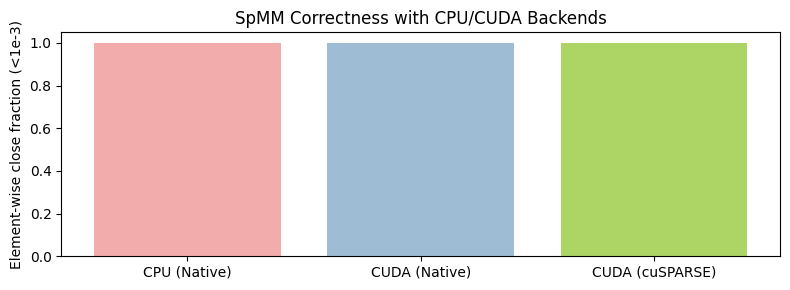

In [ ]:
# SpMM correctness: CPU vs CUDA vs cuSPARSE
import numpy as np
import matplotlib.pyplot as plt
import needle as ndl
from needle.backend_ndarray import SparseNDArray

def test_spmm(dev, seed=1):
    np.random.seed(seed)
    m = n = 64
    k = 32
    mask = (np.random.rand(m, n) > 0.9).astype(np.float32)
    dense_adj = mask * np.random.randn(m, n).astype(np.float32)
    rows, cols = np.nonzero(dense_adj)
    vals = dense_adj[rows, cols].astype(np.float32)

    A = SparseNDArray(rows, cols, vals, (m, n), device=dev)
    X = ndl.Tensor(np.random.randn(n, k).astype(np.float32), device=dev, dtype='float32', requires_grad=False)

    Y_sparse = ndl.ops.matmul(ndl.Tensor(A, device=dev, dtype='float32', requires_grad=False), X)
    Y_dense = ndl.ops.matmul(ndl.Tensor(dense_adj, device=dev, dtype='float32', requires_grad=False), X)

    diff = np.abs(Y_sparse.numpy() - Y_dense.numpy())
    return float((diff < 1e-3).mean()), len(vals), float(diff.max())


# CPU
cpu_dev = ndl.cpu()
cpu_acc, cpu_nnz, cpu_diff = test_spmm(cpu_dev)
print(f'CPU: nnz={cpu_nnz}, max_diff={cpu_diff:.2e}, accuracy={cpu_acc:.4f}')

cuda_dev = ndl.cuda()
if cuda_dev.enabled():
    # CUDA without cuSPARSE
    if hasattr(cuda_dev, 'set_use_cusparse_spmm'):
        cuda_dev.set_use_cusparse_spmm(False)
    if hasattr(cuda_dev, 'set_use_tensor_core_spmm'):
        cuda_dev.set_use_tensor_core_spmm(False)
    cuda_acc, cuda_nnz, cuda_diff = test_spmm(cuda_dev)
    print(f'CUDA: nnz={cuda_nnz}, max_diff={cuda_diff:.2e}, accuracy={cuda_acc:.4f}')

    # cuSPARSE
    if hasattr(cuda_dev, 'set_use_cusparse_spmm') and getattr(cuda_dev, '__cusparse_enabled__', False):
        cuda_dev.set_use_cusparse_spmm(True)
        cusparse_acc, cusparse_nnz, cusparse_diff = test_spmm(cuda_dev)
        print(f'cuSPARSE: nnz={cusparse_nnz}, max_diff={cusparse_diff:.2e}, accuracy={cusparse_acc:.4f}')

fig, ax = plt.subplots(figsize=(8, 3))
bars = ax.bar(['CPU (Native)', 'CUDA (Native)', 'CUDA (cuSPARSE)'],
              [cpu_acc, cuda_acc, cusparse_acc],
              color=['#EC7676', '#5D92B9', '#76B900'], alpha=0.6)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Element-wise close fraction (<1e-3)')
ax.set_title('SpMM Correctness with CPU/CUDA Backends')
plt.tight_layout()
plt.show()

### 1-2. End-to-End GCN Inference

We validate end-to-end GCN inference correctness using `GCNModel` from `apps.unified_example` across CPU and CUDA backends with both dense and sparse operations.

The following script trains and saves model weights:


In [ ]:
!python3 train_cora_gcn.py --data_dir data/cora --epochs 200 --hidden_dim 32 --num_layers 2 --dropout 0.5 --lr 0.01 --weight_decay 5e-4 --out data/cora/gcn_pytorch.npz

Epoch 010: loss=0.5356, train_acc=0.9714, val_acc=0.8260
Epoch 020: loss=0.1317, train_acc=1.0000, val_acc=0.8300
Epoch 030: loss=0.0662, train_acc=1.0000, val_acc=0.8360
Epoch 040: loss=0.0239, train_acc=1.0000, val_acc=0.8220
Epoch 050: loss=0.0359, train_acc=1.0000, val_acc=0.8240
Epoch 060: loss=0.0456, train_acc=1.0000, val_acc=0.8100
Epoch 070: loss=0.0327, train_acc=1.0000, val_acc=0.8280
Epoch 080: loss=0.0221, train_acc=1.0000, val_acc=0.8140
Epoch 090: loss=0.0283, train_acc=1.0000, val_acc=0.8220
Epoch 100: loss=0.0284, train_acc=1.0000, val_acc=0.8140
Epoch 110: loss=0.0213, train_acc=1.0000, val_acc=0.8180
Epoch 120: loss=0.0191, train_acc=1.0000, val_acc=0.8120
Epoch 130: loss=0.0232, train_acc=1.0000, val_acc=0.8120
Epoch 140: loss=0.0254, train_acc=1.0000, val_acc=0.8240
Epoch 150: loss=0.0232, train_acc=1.0000, val_acc=0.8160
Epoch 160: loss=0.0162, train_acc=1.0000, val_acc=0.8040
Epoch 170: loss=0.0230, train_acc=1.0000, val_acc=0.8140
Epoch 180: loss=0.0198, train_a

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from needle.backend_ndarray import SparseNDArray
from apps.unified_example import GCNModel, build_needle_adjacency
from apps.simple_ml import load_cora_graph

if not hasattr(ndl, "Tensor"):
    raise RuntimeError("needle import failed: make sure PYTHONPATH includes ./python and you are using Python 3.9 (tvm-0.10 env)")

weight_path = "data/cora/gcn_pytorch.npz"
try:
    with np.load(weight_path) as weights:
        hidden_features = int(weights["layers.0.weight"].shape[1])
except Exception:
    hidden_features = 32
    print(f"Falling back to hidden_features={hidden_features}; could not read {weight_path}")

results = []
configs = [
    ("cpu_dense", ndl.cpu(), False, False),
    ("cpu_sparse", ndl.cpu(), True, False),
    ("cuda_dense", ndl.cuda(), False, False),
    ("cuda_sparse", ndl.cuda(), True, False),
    ("cuda_sparse_cusparse", ndl.cuda(), True, True),
]

for name, dev, use_sparse, use_cusparse in configs:
    if not dev.enabled():
        results.append({
            "scenario": name,
            "device": str(dev),
            "use_sparse": use_sparse,
            "accuracy": None,
            "time_sec": None,
            "status": "unavailable",
            "cusparse_enabled": None,
        })
        continue

    orig_cusparse = None
    cusparse_enabled = None
    try:
        if hasattr(dev, "use_cusparse_spmm"):
            orig_cusparse = dev.use_cusparse_spmm()
        # Enable cuSPARSE if explicitly requested
        cusparse_enabled = False
        if use_cusparse and "cuda" in str(dev) and getattr(dev, "__cusparse_enabled__", False):
            if hasattr(dev, "set_use_cusparse_spmm"):
                dev.set_use_cusparse_spmm(True)
                cusparse_enabled = dev.use_cusparse_spmm()
        elif orig_cusparse is not None:
            cusparse_enabled = orig_cusparse

        print(f"Running scenario: {name} on device: {dev} with use_sparse={use_sparse} (cuSPARSE={cusparse_enabled})")

        dataset, graph = load_cora_graph("data/cora", device=dev, dtype="float32")
        adjacency = build_needle_adjacency(
            graph["edge_index"][0],
            graph["edge_index"][1],
            graph["inv_sqrt_deg"],
            sparse=use_sparse,
            device=dev,
            dtype="float32",
        )
        # Realize and keep sparse format resident on device for cuSPARSE
        adj_data = adjacency.realize_cached_data() if hasattr(adjacency, "realize_cached_data") else adjacency
        if isinstance(adj_data, SparseNDArray):
            # Touch row/col/value buffers to ensure they are on device
            _ = adj_data.row_indices
            _ = adj_data.col_indices
            _ = adj_data.values

        model = GCNModel(
            backend="needle",
            in_features=graph["features"].shape[1],
            hidden_features=hidden_features,
            num_classes=dataset.num_classes,
            num_layers=2,
            dropout=0.5,
            device=dev,
            dtype="float32",
            use_sparse=use_sparse,
        )
        model.load_weights(weight_path)

        start = time.time()
        output = model(graph["features"], adjacency)
        elapsed = time.time() - start

        predictions = output.argmax(axis=1)
        labels = graph["labels"].numpy()
        test_mask = graph["masks"]["test"]
        acc = float((predictions[test_mask] == labels[test_mask]).mean())
        status = "ok"
    except Exception as e:
        acc = None
        elapsed = None
        status = str(e)
    finally:
        if orig_cusparse is not None and hasattr(dev, "set_use_cusparse_spmm"):
            dev.set_use_cusparse_spmm(orig_cusparse)

    results.append({
        "scenario": name,
        "device": str(dev),
        "use_sparse": use_sparse,
        "accuracy": acc,
        "time_sec": elapsed,
        "status": status,
        "cusparse_enabled": cusparse_enabled,
    })

gcn_df = pd.DataFrame(results)
gcn_df

Running scenario: cpu_dense on device: cpu() with use_sparse=False (cuSPARSE=False)
Running scenario: cpu_sparse on device: cpu() with use_sparse=True (cuSPARSE=False)
Running scenario: cuda_dense on device: cuda() with use_sparse=False (cuSPARSE=True)
Running scenario: cuda_sparse on device: cuda() with use_sparse=True (cuSPARSE=True)
Running scenario: cuda_sparse_cusparse on device: cuda() with use_sparse=True (cuSPARSE=True)


,scenario,device,use_sparse,accuracy,time_sec,status,cusparse_enabled
0,cpu_dense,cpu(),False,0.83,0.814742,ok,False
1,cpu_sparse,cpu(),True,0.83,0.238795,ok,False
2,cuda_dense,cuda(),False,0.83,0.013018,ok,True
3,cuda_sparse,cuda(),True,0.83,0.027602,ok,True
4,cuda_sparse_cusparse,cuda(),True,0.83,0.029315,ok,True


Results demonstrate consistent accuracy (83%) across all backend configurations, confirming that model weights are identical. However, inference latency varies significantly across backends.




---



## **2. Performance/Efficiency Evaluation**


### 2-1: Needle Native Backend vs. TVM Backend


In [ ]:
# Inference benchmark: Needle dense/sparse vs TVM CPU/GPU
import os
import pandas as pd
from IPython.display import display
from apps.simple_ml import benchmark_gcn

DATA_DIR = "data/cora"
WEIGHT_PATH = os.path.join(DATA_DIR, "gcn_pytorch.npz")

# Configurations
benchmarks = [
    {"scenario": "cpu_needle_dense_f32", "backend": "needle", "device": "cpu", "dtype": "float32", "use_sparse": False, "use_tc": False, "cpu_inst": None},
    {"scenario": "cpu_needle_sparse_f32", "backend": "needle", "device": "cpu", "dtype": "float32", "use_sparse": True, "use_tc": False, "cpu_inst": None},
    {"scenario": "cpu_tvm_llvm_f32", "backend": "tvm", "device": "cpu", "dtype": "float32", "use_sparse": True, "use_tc": False, "cpu_inst": None},
    {"scenario": "cpu_tvm_avx2_f32", "backend": "tvm", "device": "cpu", "dtype": "float32", "use_sparse": True, "use_tc": False, "cpu_inst": "avx2"},
    {"scenario": "cpu_tvm_avx512_f32", "backend": "tvm", "device": "cpu", "dtype": "float32", "use_sparse": True, "use_tc": False, "cpu_inst": "avx512"},
    {"scenario": "gpu_needle_dense_f32", "backend": "needle", "device": "cuda", "dtype": "float32", "use_sparse": False, "use_tc": False, "cpu_inst": None},
    {"scenario": "gpu_needle_sparse_f32", "backend": "needle", "device": "cuda", "dtype": "float32", "use_sparse": True, "use_tc": False, "cpu_inst": None},
    {"scenario": "gpu_tvm_cuda_f16", "backend": "tvm", "device": "cuda", "dtype": "float16", "use_sparse": True, "use_tc": False, "cpu_inst": None},
    {"scenario": "gpu_tvm_tensorcore_f16", "backend": "tvm", "device": "cuda", "dtype": "float16", "use_sparse": True, "use_tc": True, "cpu_inst": None},
]

# Run all benchmarks
results = []
for cfg in benchmarks:
    mean_ms, std_ms, target = benchmark_gcn(
        backend=cfg["backend"],
        device_str=cfg["device"],
        use_sparse=cfg["use_sparse"],
        use_tensorcore=cfg["use_tc"],
        cpu_instruction=cfg["cpu_inst"],
        dtype=cfg["dtype"],
        DATA_DIR=DATA_DIR,
        WEIGHT_PATH=WEIGHT_PATH,
        warmup=10,
        runs=100,
    )
    results.append({
        "scenario": cfg["scenario"],
        "backend": cfg["backend"],
        "device": cfg["device"],
        "dtype": cfg["dtype"],
        "use_sparse": cfg["use_sparse"],
        "use_tensorcore": cfg["use_tc"],
        "cpu_instruction": cfg["cpu_inst"],
        "target": target,
        "mean_ms": mean_ms,
        "std_ms": std_ms,
        "status": "ok",
    })

df = pd.DataFrame(results)
display(df)

✓ Force Tensor Core mode enabled (will pad dimensions if needed)
✓ Registered Tensor Core strategies for CUDA (FORCED - no fallback)
  [Relay Build] A_compressed numpy shape: (2752, 2752)
  [Relay Build] M_padded from params: 2752, K_padded from params: 2752
  [GraphConv DTC] Reshaped A_compressed to (2752, 2752) for Relay shape inference
  [GraphConv DTC] Reshaped A_compressed to (2752, 2752) for Relay shape inference


,scenario,backend,device,dtype,use_sparse,use_tensorcore,cpu_instruction,target,mean_ms,std_ms,status
0,cpu_needle_dense_f32,needle,cpu,float32,False,False,None,None,473.548413,79.053640,ok
1,cpu_needle_sparse_f32,needle,cpu,float32,True,False,None,None,159.526639,23.578062,ok
2,cpu_tvm_llvm_f32,tvm,cpu,float32,True,False,None,llvm,6.442672,0.267310,ok
3,cpu_tvm_avx2_f32,tvm,cpu,float32,True,False,avx2,llvm -mcpu=core-avx2,6.633882,0.458218,ok
4,cpu_tvm_avx512_f32,tvm,cpu,float32,True,False,avx512,llvm -mcpu=skylake-avx512,6.284681,0.209227,ok
5,gpu_needle_dense_f32,needle,cuda,float32,False,False,None,None,11.696637,0.088835,ok
6,gpu_needle_sparse_f32,needle,cuda,float32,True,False,None,None,19.879535,1.626838,ok
7,gpu_tvm_cuda_f16,tvm,cuda,float16,True,False,None,cuda,2.097325,0.123678,ok
8,gpu_tvm_tensorcore_f16,tvm,cuda,float16,True,True,None,cuda,2.708644,0.009720,ok


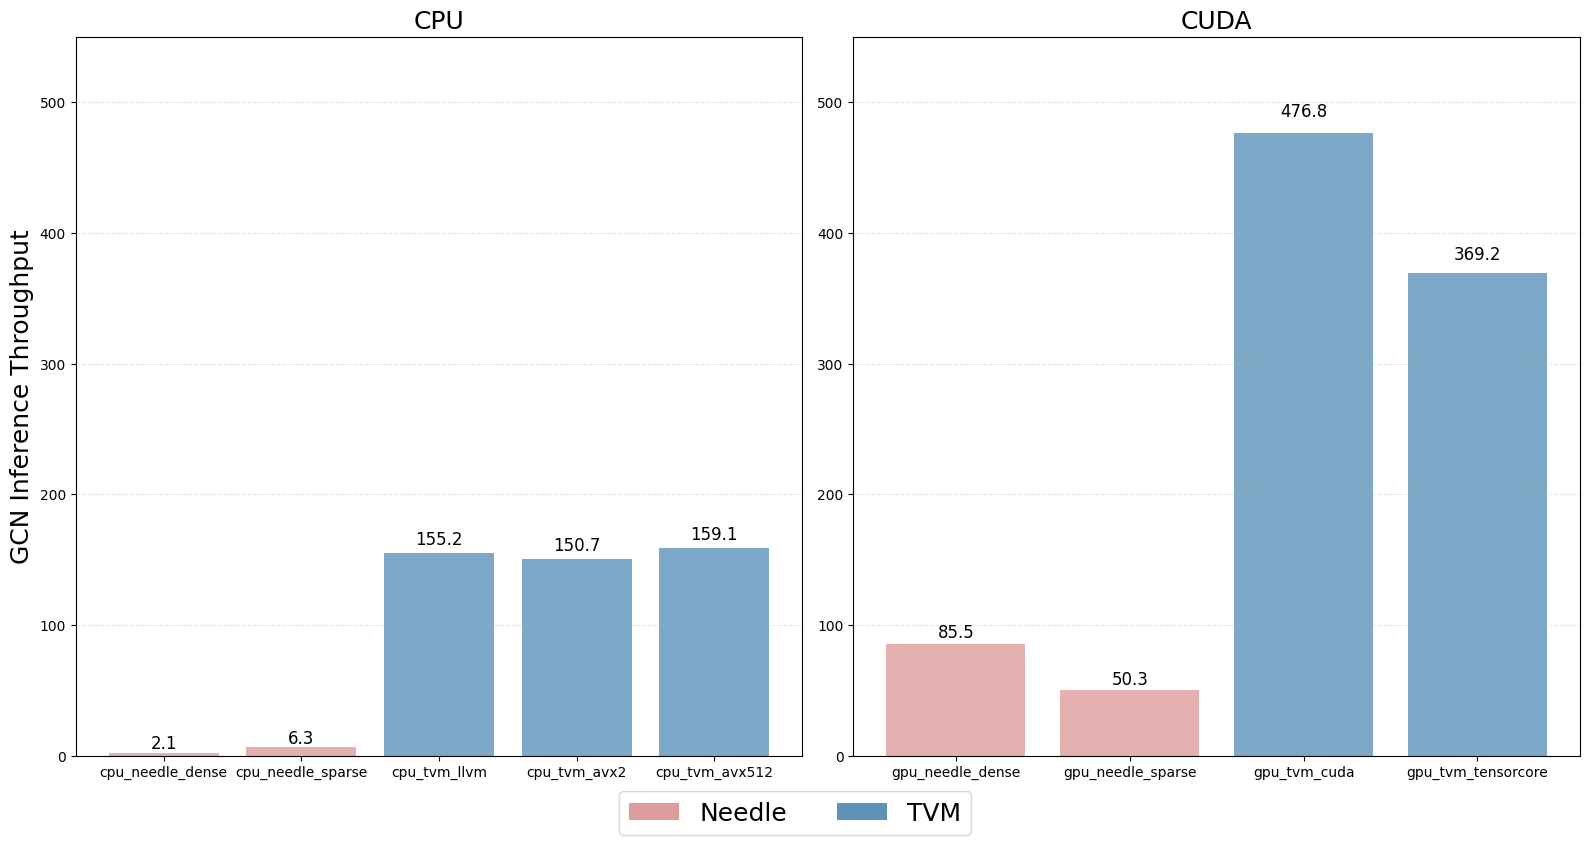

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

ok_df = df[df["status"] == "ok"]

ok_df = ok_df.copy()
ok_df['throughput'] = 1000.0 / ok_df['mean_ms']
ok_df['throughput_err'] = ok_df['throughput'] * (ok_df['std_ms'] / ok_df['mean_ms'])

cpu_df = ok_df[ok_df['device'] == 'cpu'].copy()
cuda_df = ok_df[ok_df['device'] == 'cuda'].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left subplot: CPU
positions_cpu = np.arange(len(cpu_df))
colors_cpu = ["#5D92B9" if b != "needle" else "#DE9D9D" for b in cpu_df["backend"]]
bars_cpu = ax1.bar(positions_cpu, cpu_df["throughput"],
                    color=colors_cpu, alpha=0.8, capsize=5)
ax1.set_xticks(positions_cpu)
ax1.set_xticklabels([s.split('_f')[0] for s in cpu_df["scenario"]], rotation=0, ha="center")
ax1.set_ylabel("GCN Inference Throughput", fontsize=18)
ax1.set_ylim(0, 550)
ax1.set_title("CPU", fontsize=18)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

for i, (bar, throughput) in enumerate(zip(bars_cpu, cpu_df["throughput"])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + height * 0.02,
            f"{throughput:.1f}", ha="center", va="bottom", fontsize=12)


# Right subplot: CUDA
positions_cuda = np.arange(len(cuda_df))
colors_cuda = ["#5D92B9" if b != "needle" else "#DE9D9D" for b in cuda_df["backend"]]
bars_cuda = ax2.bar(positions_cuda, cuda_df["throughput"],
                    color=colors_cuda, alpha=0.8, capsize=5)
ax2.set_xticks(positions_cuda)
ax2.set_xticklabels([s.split('_f')[0] for s in cuda_df["scenario"]], rotation=0, ha="center")
ax2.set_ylim(0, 550)
ax2.set_title("CUDA", fontsize=18)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

for i, (bar, throughput) in enumerate(zip(bars_cuda, cuda_df["throughput"])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + height * 0.02,
            f"{throughput:.1f}", ha="center", va="bottom", fontsize=12)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#DE9D9D', label='Needle'),
    Patch(facecolor='#5D92B9', label='TVM')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02), fontsize=18)
plt.tight_layout()
plt.show()

### 2-2. Auto-Scheduling


In [ ]:
from apps.unified_example import GCNModel
from needle.data.datasets.cora_dataset import CoraDataset
from apps.simple_ml import benchmark_gcn

dataset = CoraDataset(root="data/cora")
model = GCNModel(
            backend="tvm",
            dataset=dataset,
            hidden_features=32,
            num_layers=2,
            device="cpu",
            opt_level=3,
            cpu_instruction_set="avx512",
            use_gpu_mma=False,
            dtype="float32",
            activation=None,
        )

model.compile()

print(benchmark_gcn(
    backend="tvm", device_str="cpu", cpu_instruction="avx512",
    dtype="float32", runs=20, warmup=5, model=model,
))

model.tune(log_file="gcn_tvm_cpu_avx512_1.log", verbose=False,
           runner_timeout=30, runner_number=1, runner_repeat=1, runner_min_repeat_ms=500)

model.compile(use_tuning=True)

print(benchmark_gcn(
    backend="tvm", device_str="cpu", cpu_instruction="avx512",
    dtype="float32", runs=20, warmup=5, model=model,
))

(8.28899338375777, 0.7291272377333393, 'llvm -mcpu=skylake-avx512')
----------------------------------------------------------------------
------------------------------  [ Call init-search callbacks ]
----------------------------------------------------------------------
Custom sketch rule "SparseDense" added.
----------------------------------------------------------------------
------------------------------  [ Search ]
----------------------------------------------------------------------
Generate Sketches		#s: 1
Sample Initial Population	#s: 659	fail_ct: 1389	Time elapsed: 0.88
GA Iter: 0	Max score: 0.9978	Min score: 0.8040	#Pop: 128	#M+: 0	#M-: 0
GA Iter: 4	Max score: 0.9996	Min score: 0.9782	#Pop: 128	#M+: 1378	#M-: 81
EvolutionarySearch		#s: 128	Time elapsed: 2.70
----------------------------------------------------------------------
------------------------------  [ Measure ]
----------------------------------------------------------------------
Get 40 programs to measure:
...

Benchmark results demonstrate that GCN inference with LLVM + AVX-512 achieves **1.9x speedup** (from 8.28 ms to 4.41 ms) compared to standard LLVM compilation.

**Tuning Parameters**:
- Main Tile (K dimension): N/A → [64, 4]
- Block Tile (J dimension): N/A → [1]
- Unroll Step: 0 → 64

**Key Optimization**: TVM performs loop unrolling to fully utilize SIMD instructions. AVX-512 provides 512-bit registers capable of processing **16 float32 elements** simultaneously (512 bits ÷ 32 bits per float32 = 16 elements). TVM's auto-tuning framework unrolls inner loops to process 32+ elements per iteration, enabling efficient vectorization and maximizing register utilization.


## Appendix

### **1. Sparse Format Conversion**

In [ ]:
# Helper: convert adjacency to CSR (row_ptr, col_idx, values) for sparse efficiency tests
import numpy as np
import needle as ndl
from needle.backend_ndarray import SparseNDArray

def adjacency_to_csr(adjacency):
    """Return CSR triplets as numpy arrays for a dense or SparseNDArray adjacency."""
    adj_data = adjacency.realize_cached_data() if isinstance(adjacency, ndl.Tensor) else adjacency
    if isinstance(adj_data, SparseNDArray):
        rows = adj_data.row_indices.numpy().astype(np.int64)
        cols = adj_data.col_indices.numpy().astype(np.int64)
        vals = adj_data.values.numpy().astype(np.float32)
        m, _ = adj_data.shape
    else:
        dense = adj_data.numpy() if hasattr(adj_data, "numpy") else np.array(adj_data, dtype=np.float32)
        m, _ = dense.shape
        rows, cols = np.nonzero(dense)
        vals = dense[rows, cols].astype(np.float32)
    order = np.lexsort((cols, rows))
    rows, cols, vals = rows[order], cols[order], vals[order]
    row_ptr = np.zeros(m + 1, dtype=np.int64)
    np.add.at(row_ptr, rows + 1, 1)
    row_ptr = np.cumsum(row_ptr)
    return row_ptr, cols.astype(np.int64), vals


### **2. CSR vs. COO Sparse Format**

In [ ]:
# CUDA inference throughput: COO vs CSR reformat (captures CUDA SpMM fprintf)
import os, time, numpy as np, pandas as pd, needle as ndl, threading
from needle.backend_ndarray import SparseNDArray
from apps.simple_ml import load_cora_graph
from apps.unified_example import GCNModel as UnifiedGCN, build_needle_adjacency

DATA_DIR = "data/cora"
WEIGHT_PATH = os.path.join(DATA_DIR, "gcn_pytorch.npz")

hidden_features = 32
if os.path.exists(WEIGHT_PATH):
    try:
        with np.load(WEIGHT_PATH) as weights:
            hidden_features = int(weights["layers.0.weight"].shape[1])
    except Exception:
        pass

if "adjacency_to_csr" not in globals():
    raise RuntimeError("adjacency_to_csr helper not defined; run helper cell first.")

class NativeStderrCapture:
    def __enter__(self):
        self._orig_fd = os.dup(2)
        self._read_fd, w = os.pipe()
        os.dup2(w, 2)
        os.close(w)
        self._chunks = []
        def _reader():
            while True:
                try:
                    data = os.read(self._read_fd, 4096)
                except OSError:
                    break
                if not data:
                    break
                self._chunks.append(data)
        self._t = threading.Thread(target=_reader, daemon=True)
        self._t.start()
        return self
    def __exit__(self, exc_type, exc, tb):
        os.dup2(self._orig_fd, 2)
        os.close(self._orig_fd)
        self._t.join()
        os.close(self._read_fd)
        self.output = b"".join(self._chunks).decode(errors="replace")


def build_inputs(dev):
    dataset, graph = load_cora_graph(DATA_DIR, device=dev, dtype="float32")
    adj_coo = build_needle_adjacency(
        graph["edge_index"][0],
        graph["edge_index"][1],
        graph["inv_sqrt_deg"],
        sparse=True,
        device=dev,
        dtype="float32",
    )
    row_ptr, col_idx, vals = adjacency_to_csr(adj_coo)
    num_nodes = row_ptr.shape[0] - 1
    rows_sorted = np.repeat(np.arange(num_nodes, dtype=np.int64), np.diff(row_ptr))
    adj_csr = ndl.Tensor(
        SparseNDArray(rows_sorted, col_idx, vals, (num_nodes, num_nodes), device=dev),
        device=dev, dtype="float32", requires_grad=False,
    )
    return dataset, graph, adj_coo, adj_csr

def bench_adj(adjacency, graph, dataset, dev, warmup=5, runs=20):
    model = UnifiedGCN(
        backend="needle",
        in_features=graph["features"].shape[1],
        hidden_features=hidden_features,
        num_classes=dataset.num_classes,
        num_layers=2,
        dropout=0.5,
        device=dev,
        dtype="float32",
        use_sparse=True,
    )
    if os.path.exists(WEIGHT_PATH):
        model.load_weights(WEIGHT_PATH)
    for _ in range(warmup):
        _ = model(graph["features"], adjacency)
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        _ = model(graph["features"], adjacency)
        times.append((time.perf_counter() - start) * 1000)
    return float(np.mean(times)), float(np.std(times))

dev = ndl.cuda()
print("CUDA enabled:", dev.enabled())
print("cuSPARSE built:", getattr(dev, "__cusparse_enabled__", False))
if not dev.enabled():
    print("CUDA unavailable; skipping")
else:
    orig_cusparse = dev.use_cusparse_spmm() if hasattr(dev, "use_cusparse_spmm") else None
    orig_tc = dev.use_tensor_core_spmm() if hasattr(dev, "use_tensor_core_spmm") else None
    try:
        if hasattr(dev, "set_use_tensor_core_spmm"):
            dev.set_use_tensor_core_spmm(False)
        if hasattr(dev, "set_use_cusparse_spmm") and getattr(dev, "__cusparse_enabled__", False):
            dev.set_use_cusparse_spmm(True)
        dataset, graph, adj_coo, adj_csr = build_inputs(dev)
        # Explicitly trigger CUDA SpMM once per format to show fprintf
        for name, adj in [("coo", adj_coo), ("csr_reformat", adj_csr)]:
            with NativeStderrCapture() as cap:
                _ = ndl.ops.matmul(adj, graph["features"])
            print(f"[{name}] stderr: {cap.output.strip() or '<empty>'}")
        results = []
        for name, adj in [("coo", adj_coo), ("csr_reformat", adj_csr)]:
            mean_ms, std_ms = bench_adj(adj, graph, dataset, dev)
            results.append({"adj": name, "mean_ms": mean_ms, "std_ms": std_ms})
        display(pd.DataFrame(results))
    finally:
        if orig_tc is not None and hasattr(dev, "set_use_tensor_core_spmm"):
            dev.set_use_tensor_core_spmm(orig_tc)
        if orig_cusparse is not None and hasattr(dev, "set_use_cusparse_spmm"):
            dev.set_use_cusparse_spmm(orig_cusparse)


CUDA enabled: True
cuSPARSE built: True
[coo] stderr: <empty>
[csr_reformat] stderr: <empty>


,adj,mean_ms,std_ms
0,coo,22.770149,0.808443
1,csr_reformat,22.321190,1.234769


### **3. Why Needle's CUDA Sparse Can Be Slower Than Dense**

For small graphs like Cora, sparse SpMM may be slower than dense GEMM due to:

1. **Fixed overhead dominance**: Small graphs with low hidden dimensions result in fixed overhead (handle setup, buffer allocation, synchronization) dominating sparse SpMM execution time.

2. **Format conversion overhead**: The current CUDA implementation converts COO to CSR and casts float indices to integers on each call, with fresh memory allocations instead of reusing persistent resources.

3. **Optimization differences**: Tensor Core SpMM is disabled to force cuSPARSE usage, while the dense path may leverage more efficient kernels and instructions.

4. **Limited optimizations**: No half-precision or Tensor Core optimizations for SpMM, and no CSR descriptor reuse or persistent workspace, causing the sparse path to lag on small graphs.


In [ ]:
# Standalone CUDA dense matmul vs SpMM operator test (synthetic)
import time, numpy as np, pandas as pd, needle as ndl
from needle.backend_ndarray import SparseNDArray

# Config
m = n = 512  # square sparse matrix size
k = 128      # feature dim
sparsity = 0.02  # fraction of nonzeros
runs = 50
warmup = 5

dev = ndl.cuda()
print('CUDA enabled:', dev.enabled())
print('cuSPARSE built:', getattr(dev, '__cusparse_enabled__', False))
if not dev.enabled():
    print('CUDA unavailable; skipping test')
else:
    # Toggle flags: disable tensor core, enable cuSPARSE if present
    orig_tc = dev.use_tensor_core_spmm() if hasattr(dev, 'use_tensor_core_spmm') else None
    orig_cusparse = dev.use_cusparse_spmm() if hasattr(dev, 'use_cusparse_spmm') else None
    try:
        if hasattr(dev, 'set_use_tensor_core_spmm'):
            dev.set_use_tensor_core_spmm(False)
        if hasattr(dev, 'set_use_cusparse_spmm') and getattr(dev, '__cusparse_enabled__', False):
            dev.set_use_cusparse_spmm(True)

        # Build synthetic sparse and dense matrices
        rng = np.random.default_rng(0)
        mask = (rng.random((m, n)) < sparsity)
        rows, cols = np.nonzero(mask)
        vals = rng.standard_normal(size=rows.shape[0]).astype(np.float32)
        A_sparse = SparseNDArray(rows, cols, vals, (m, n), device=dev)
        A_dense = np.zeros((m, n), dtype=np.float32)
        A_dense[rows, cols] = vals
        A_dense = ndl.Tensor(A_dense, device=dev, dtype='float32', requires_grad=False)

        X = ndl.Tensor(rng.standard_normal((n, k)).astype(np.float32), device=dev, requires_grad=False)

        def bench(A, name):
            for _ in range(warmup):
                _ = ndl.ops.matmul(A, X)
            times = []
            for _ in range(runs):
                start = time.perf_counter()
                _ = ndl.ops.matmul(A, X)
                times.append((time.perf_counter() - start) * 1000)
            return float(np.mean(times)), float(np.std(times))

        res = []
        md, sd = bench(A_dense, 'dense')
        res.append({'op': 'dense_matmul', 'mean_ms': md, 'std_ms': sd})
        ms, ss = bench(ndl.Tensor(A_sparse, device=dev, requires_grad=False), 'spmm_sparse')
        res.append({'op': 'spmm_sparse', 'mean_ms': ms, 'std_ms': ss})
        display(pd.DataFrame(res))
    finally:
        if orig_tc is not None and hasattr(dev, 'set_use_tensor_core_spmm'):
            dev.set_use_tensor_core_spmm(orig_tc)
        if orig_cusparse is not None and hasattr(dev, 'set_use_cusparse_spmm'):
            dev.set_use_cusparse_spmm(orig_cusparse)

CUDA enabled: True
cuSPARSE built: True


,op,mean_ms,std_ms
0,dense_matmul,0.024714,0.014721
1,spmm_sparse,1.102285,0.122898




---



## References

### **Papers**

- T. N. Kipf and M. Welling, "Semi-Supervised Classification with Graph Convolutional Networks," in *International Conference on Learning Representations (ICLR)*, 2017. [arXiv:1609.02907](https://arxiv.org/abs/1609.02907)

- T. Chen, T. Moreau, Z. Jiang, L. Zheng, E. Yan, H. Shen, M. Cowan, L. Wang, Y. Hu, L. Ceze, C. Guestrin, and A. Krishnamurthy, "TVM: An Automated End-to-End Optimizing Compiler for Deep Learning," in *13th USENIX Symposium on Operating Systems Design and Implementation (OSDI)*, 2018. [arXiv:1803.08601](https://arxiv.org/abs/1803.08601)

- W. Wang, Y. Zhang, Z. Jia, Y. Tang, J. Wang, H. Yang, and S. Luo, "DTC-SpMM: Bridging the Gap in Accelerating General Sparse Matrix Multiplication with Tensor Cores," in *Proceedings of the 29th ACM International Conference on Architectural Support for Programming Languages and Operating Systems (ASPLOS)*, 2024. [DOI: 10.1145/3620666.3651378](https://dl.acm.org/doi/abs/10.1145/3620666.3651378)

- J. Shi, S. Li, Y. Xu, R. Fu, X. Wang, and T. Wu, "FlashSparse: Minimizing Computation Redundancy for Fast Sparse Matrix Multiplications on Tensor Cores," in *30th ACM SIGPLAN Annual Symposium on Principles and Practice of Parallel Programming (PPoPP)*, 2025. [arXiv:2412.11007](https://arxiv.org/abs/2412.11007)

- Z. Ye, R. Lai, J. Shao, T. Chen, and L. Ceze, "SparseTIR: Composable Abstractions for Sparse Compilation in Deep Learning," in *Proceedings of the 28th ACM International Conference on Architectural Support for Programming Languages and Operating Systems (ASPLOS)*, 2023. [arXiv:2207.04606](https://arxiv.org/abs/2207.04606) [DOI: 10.1145/3582016.3582047](https://doi.org/10.1145/3582016.3582047)

- Y. Zhang, Z. Jia, W. Wang, Y. Tang, J. Wang, H. Yang, and S. Luo, "Acc-SpMM: Accelerating General-purpose Sparse Matrix-Matrix Multiplication with GPU Tensor Cores," 2025. [arXiv:2501.09251](https://arxiv.org/abs/2501.09251)

### **Libraries and Frameworks**

- **PyTorch Geometric**: A geometric deep learning extension library for PyTorch. [GitHub](https://github.com/pyg-team/pytorch_geometric)

- **Deep Graph Library (DGL)**: A Python package for deep learning on graphs. [Website](https://www.dgl.ai/)

- **TVM**: An open source machine learning compiler framework for CPUs, GPUs, and specialized accelerators. [Website](https://tvm.apache.org/)

- **LLVM**: A collection of modular and reusable compiler and toolchain technologies. [Website](https://llvm.org/)

- **NVIDIA cuSPARSE Library**: A library of sparse matrix routines for CUDA. [User Guide](https://docs.nvidia.com/cuda/cusparse/)

- **NVIDIA cuBLAS Library**: A GPU-accelerated library for basic linear algebra subroutines. [User Guide](https://docs.nvidia.com/cuda/cublas/)

- **NVIDIA Tensor Core**: Specialized processing units for mixed-precision matrix multiplication and accumulation. [Documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#wmma)

- **NVIDIA WMMA API**: Warp-level matrix multiply-accumulate API for Tensor Cores. [Documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#wmma)

- **Intel MKL (Math Kernel Library)**: A library of optimized math routines for Intel processors. [Website](https://www.intel.com/content/www/us/en/developer/tools/oneapi/onemkl.html)